In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


In [29]:
df = pd.read_csv("operadata_2904.csv")

drop_cols = [
    "IOT_ASSET_CODE", "LSWorkType", "Monthvalues", "YearValues", "MthYr",
    "Asset_Description", "PlantMasterDescription", "FGDescription",
    "LFProductivityPercent", "FSFProductivityPercent", "AssetMonthYr",
    "SFProductivityPercent", "UtilizationStatus_Month"
]
df.drop(columns=drop_cols, inplace=True, errors='ignore')
df.fillna(0, inplace=True)
df = df.select_dtypes(include=[np.number])

target_column = "WorkDoneQTY_Considered"
feature_columns = [col for col in df.columns if col != target_column]
X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()


In [30]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1,max_iter=10000)
}

results = []

for name, model in linear_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results.append({
        "Model": name,
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred)
    })


In [31]:

rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_

gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]}
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=3, scoring='r2', n_jobs=-1)
gb_grid.fit(X_train_scaled, y_train)
gb_best = gb_grid.best_estimator_

for name, model in zip(["Random Forest", "Gradient Boosting"], [rf_best, gb_best]):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results.append({
        "Model": name,
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred)
    })


In [32]:
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler()),
    ('lr', LinearRegression())
])

poly_pipeline.fit(X_train, y_train)
poly_pred = poly_pipeline.predict(X_test)

results.append({
    "Model": "Polynomial Regression (deg=2)",
    "R2": r2_score(y_test, poly_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, poly_pred)),
    "MAE": mean_absolute_error(y_test, poly_pred)
})


In [33]:
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print(results_df)

rf_importance_df = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": rf_best.feature_importances_
}).sort_values(by="Importance", ascending=False)
print(rf_importance_df)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
print(X_pca_df.head())


                           Model            R2          RMSE           MAE
4              Gradient Boosting  9.986369e-01  6.961494e+02  7.518023e+01
3                  Random Forest  9.955371e-01  1.259626e+03  9.189832e+01
1               Ridge Regression  9.881885e-01  2.049200e+03  4.672697e+02
2               Lasso Regression  9.881718e-01  2.050652e+03  4.671219e+02
0              Linear Regression  9.881641e-01  2.051314e+03  4.673906e+02
5  Polynomial Regression (deg=2) -1.092580e+17  6.232450e+12  1.120104e+11
                       Feature  Importance
11            LogSheetWorkDone    0.934804
7                      BU_CODE    0.012706
6                      IC_CODE    0.012052
9                    Deviation    0.008212
19      ExpectedHrs_Considered    0.006076
2                     IOTRunHr    0.005019
3                LOGSheetRunHr    0.004582
10                 IOTWOrkDone    0.003467
5               LogUtilization    0.003002
22              ActualIssueQty    0.002361
17

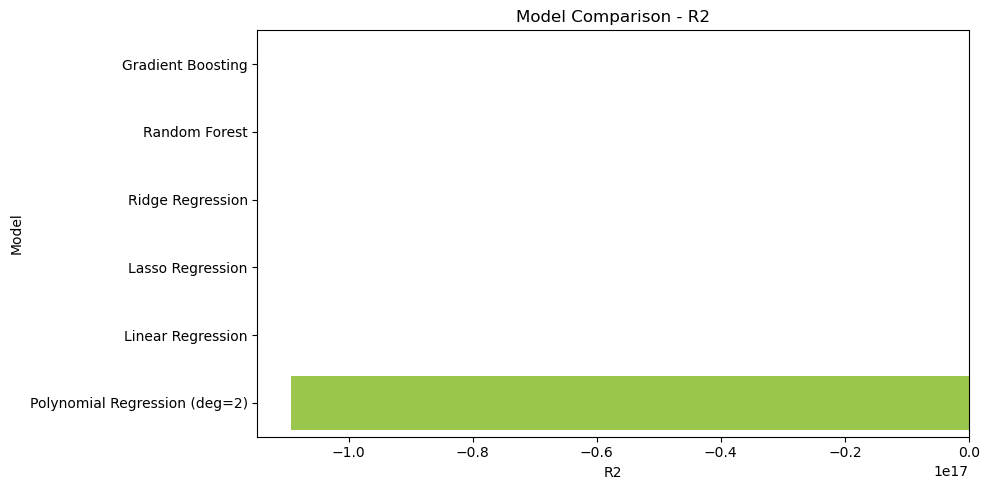

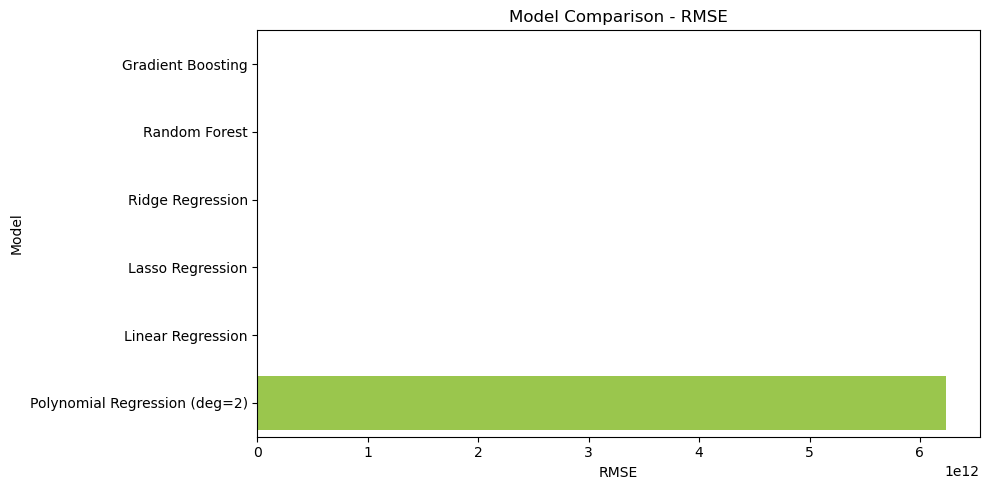

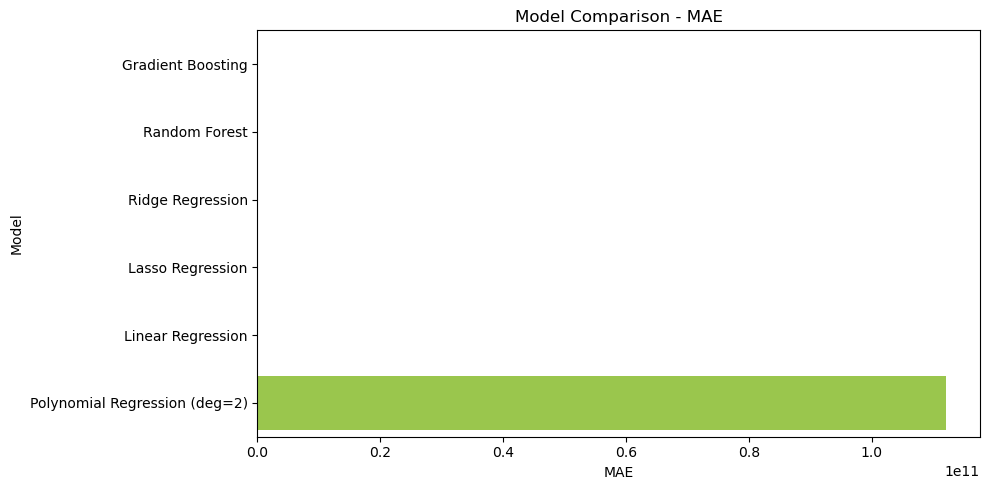

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to DataFrame if not already
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)

# Plot R², RMSE, MAE
metrics = ["R2", "RMSE", "MAE"]
for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=metric, y="Model", data=results_df, palette="viridis")
    plt.title(f"Model Comparison - {metric}")
    plt.xlabel(metric)
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()


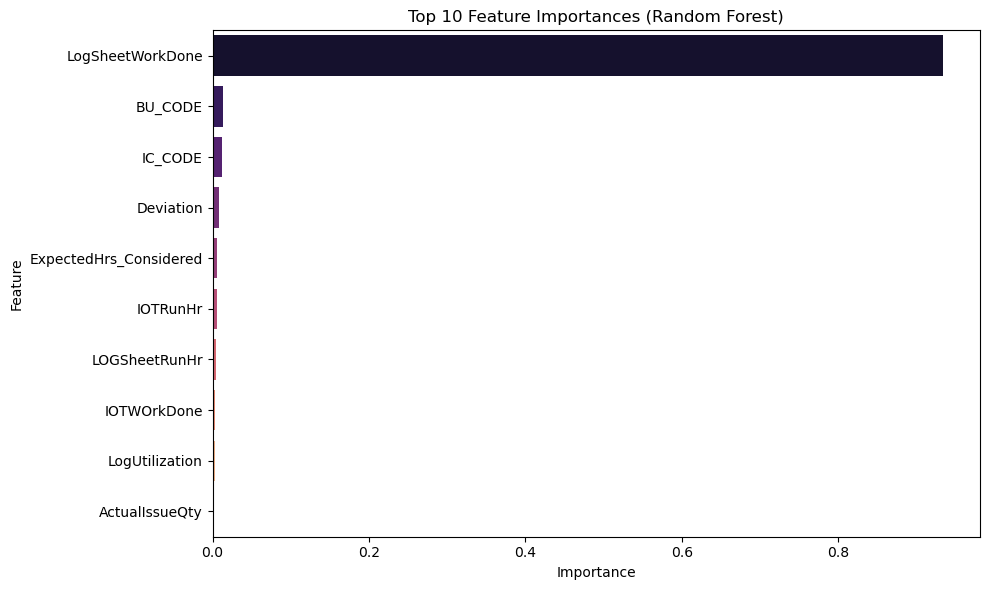

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=rf_importance_df.head(10), palette="magma")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


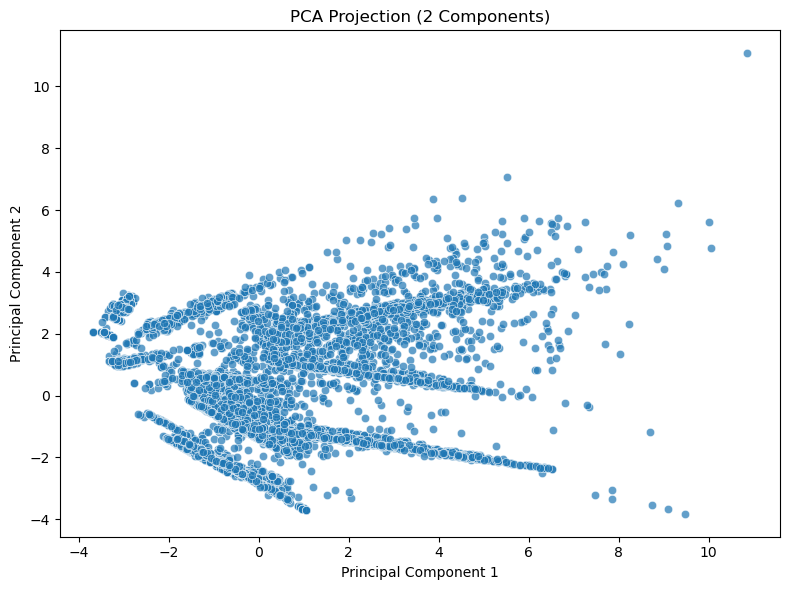

In [36]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", data=X_pca_df, alpha=0.7)
plt.title("PCA Projection (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


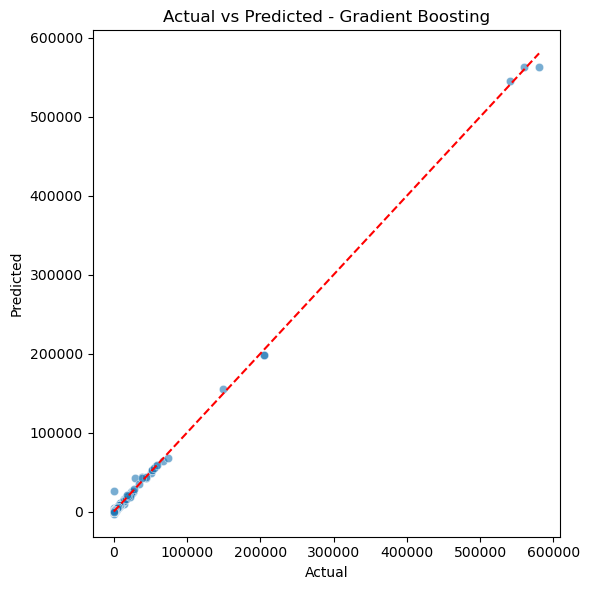

In [37]:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {name}")
    plt.tight_layout()
    plt.show()
